# Abstract classification

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer #TF-IDF is not suitable for LDA because wordcounts required
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# scientific units
from quantities import units
import utils # all datareading and preprocessing functionality

## Current analysis configuration

In [2]:
file1 = './data/abstract_set1.txt' # pesticides
file2 = './data/abstract_set2.txt' # cancer-ish
data_selection = 'abstract_clean'
label_selection = 'label'

In [3]:
# the custom class Tokenizer can also lemmatize, and remove short words, digits and stopwords
stopwords = utils.get_stopwords(custom = {'wa', 'use', 'using', 'one', 'two', 'three', 'study'}) 
#custom = {'pesticide', 'pesticides'})

tokenizer = utils.Tokenizer(stop_words=stopwords, min_length=3)
#tokenizer = utils.StemTokenizer()

#vectorizer = TfidfVectorizer(tokenizer=tokenizer)
vectorizer = CountVectorizer(tokenizer=tokenizer) 

**Note** I have tried with and without the words "pesticide" and "pesticides" present in `stopwords`, but this had only minor effect on the performance of the different models.

**Note** The word 'wa' appeared in all categories with lda; this is probably a lemmatization thing. Put it nito the stopwords set.

## Load, preprocess and inspect

In [ ]:
#run this to relad the utils module after changes during session
from importlib import reload 
reload(utils);

In [6]:
data = utils.read_abstract_data(negatives_path=file2, positives_path=file1)

# no need to catch return value; dataframe operations are in-place
# no need to remove punctuation in this step when using nltk.tokenize_word() 
# which is implemented in utils.tokenize_text()
utils.preprocess_text(data)

data.head()

,pmid,title,abstract,label,text_label,title_clean,abstract_clean
0,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...,"BACKGROUND: Breast cancer subtype, as determin...",0,control,impact of neoadjuvant chemotherapy on breast c...,"background: breast cancer subtype, as determin..."
1,29984001,Expert-Performed Endotracheal Intubation-Relat...,The aim of this study was to determine complic...,0,control,expert-performed endotracheal intubation-relat...,the aim of this study was to determine complic...
2,29988545,A case report: Addison disease caused by adren...,We report middle age man with skin hyperpigmen...,0,control,a case report: addison disease caused by adren...,we report middle age man with skin hyperpigmen...
3,29998100,An Unusual Morphological Presentation of Cutan...,Cutaneous squamous cell carcinoma (SCC) exhibi...,0,control,an unusual morphological presentation of cutan...,cutaneous squamous cell carcinoma (scc) exhibi...
4,29999256,Informing Consent: Medical Malpractice and the...,"Since the early 1990s, jurisdictions around th...",0,control,informing consent: medical malpractice and the...,"since the early 1990s, jurisdictions around th..."


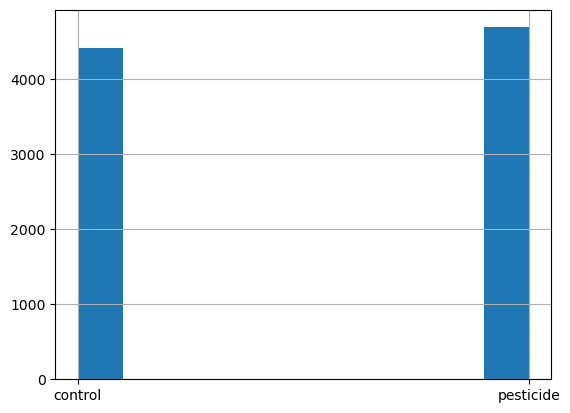

In [9]:
data['text_label'].hist();

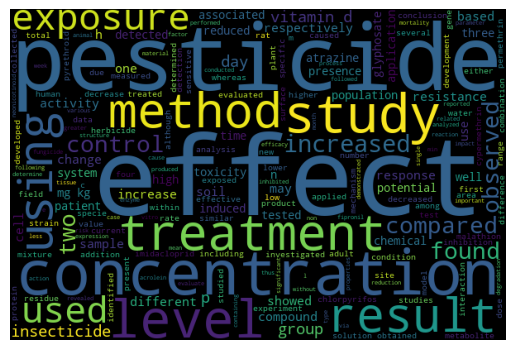

In [10]:
utils.visualize(data, 'pesticide')

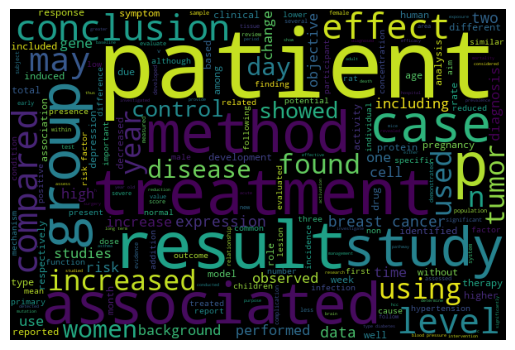

In [11]:
utils.visualize(data, 'control')

## Create train and test data


In [12]:
x_train, x_test, y_train, y_test = train_test_split(data[data_selection], data[label_selection], random_state=123)
x_train.head()

801     neuroblastoma x glioma hybrid, ng108-15, cells...
9400    cyfluthrin is widely used in the field of sani...
7891    a periodic mesoporous organosilica, in particu...
5073    sodium-ion batteries (sibs), a promising candi...
6472    five pesticides, i.e. carbaryl, simazine, atra...
Name: abstract_clean, dtype: object

In [13]:
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# Note the use of different functions for train and test data !

x_train_vec.shape # is a sparse matrix!

/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(6832, 51148)

In [14]:
# what percentage of values are non-zero?
(x_train_vec != 0).sum() / np.prod(x_train_vec.shape) 
## -> 0.0016455823612711938

0.0015999598858911339

## Topic modeling

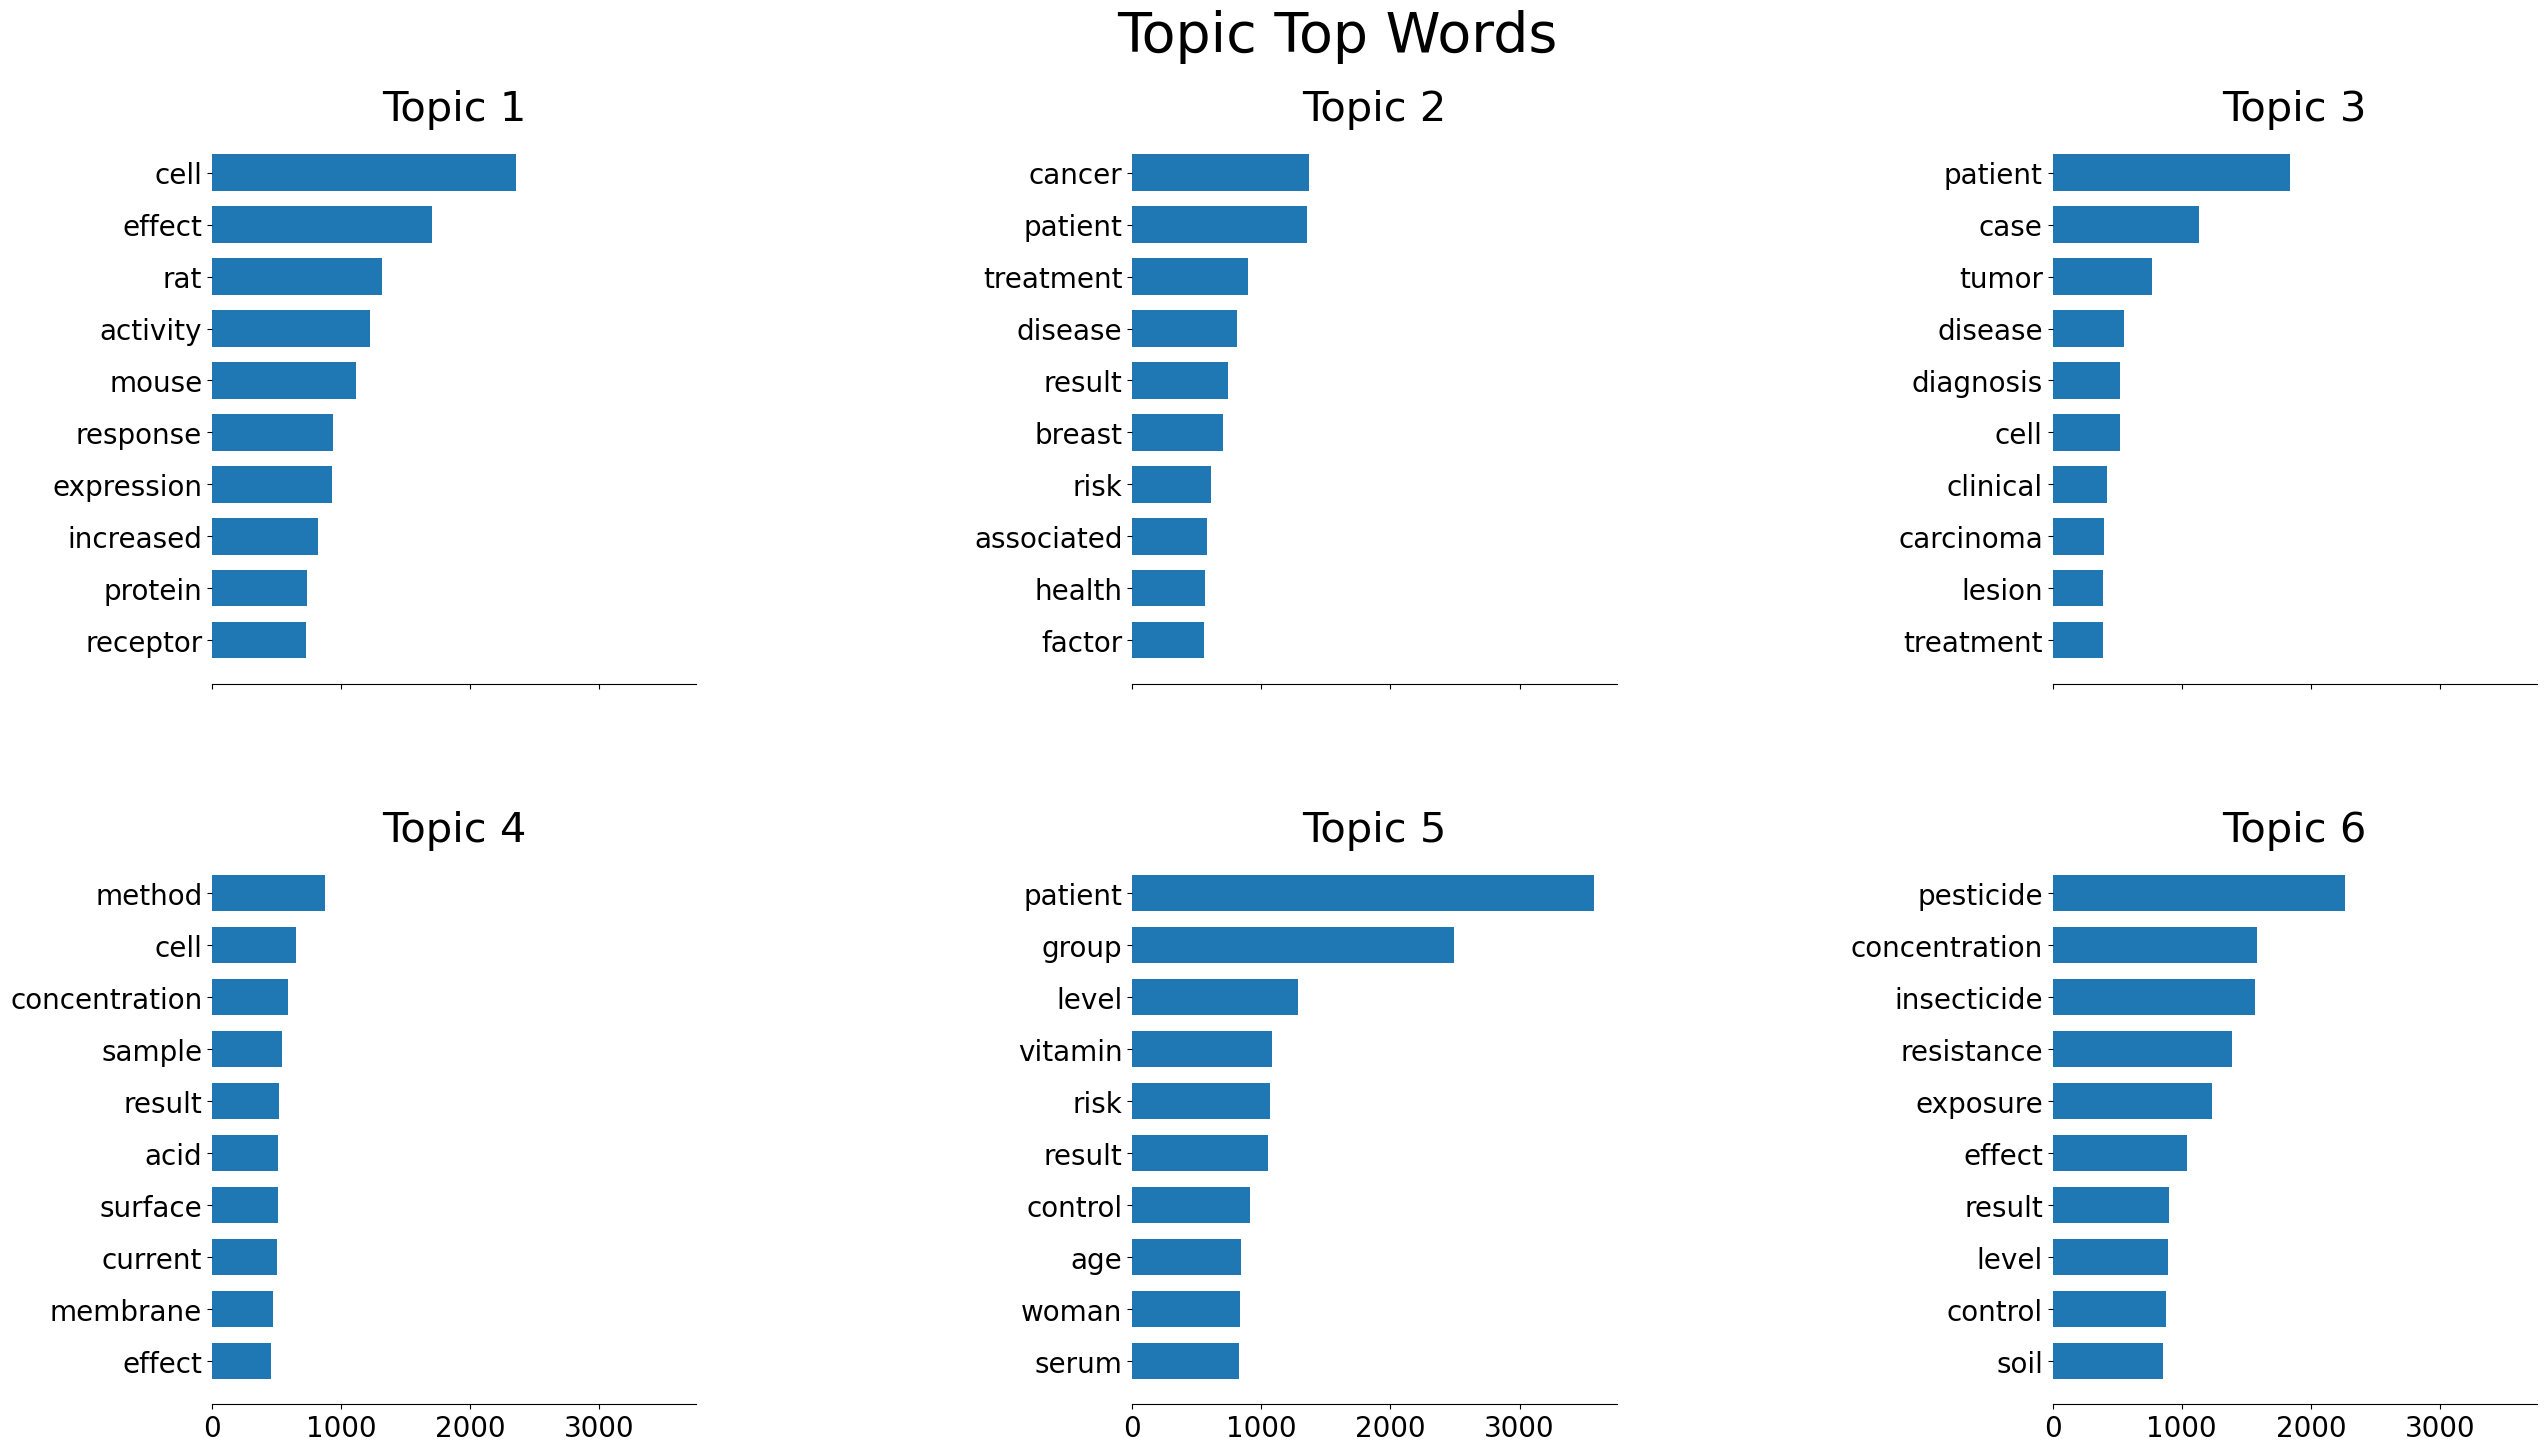

In [15]:
if isinstance(vectorizer, CountVectorizer):
    n_components = 6
    lda = LatentDirichletAllocation(n_components=n_components, random_state=12345)

    lda.fit(x_train_vec) # takes quite some time and memory
    # feature_names are column indices to the countvectorizer model
    feature_names = vectorizer.get_feature_names_out()
    utils.plot_top_words(lda, feature_names, n_components = n_components, n_top_words=10);
else:
    print("skipping Topic modeling when vectorizer is not a CountVectorizer ")


## Classification models

### Naive Bayes

In [16]:
model = MultinomialNB() 
model.fit(x_train_vec, y_train)

MultinomialNB()

test accuracy:  0.91264
train accuracy: 0.96092
test precision: 0.91617
test recall:    0.91382
test F1 score:  0.91499
confusion matrix:
[[1008   98]
 [ 101 1071]]


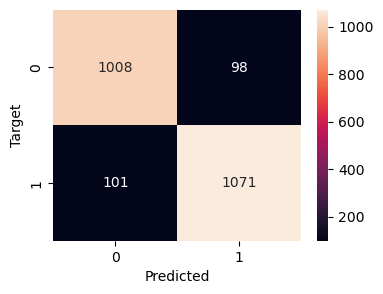

In [20]:
eval_results = utils.evaluate_model(model, x_train_vec, y_train, x_test_vec, y_test)
utils.plot_confusion_matrix(eval_results['confusion_matrix'], model.classes_)

#### With TfidfVectorizer
```
train accuracy: 0.94804  
test accuracy:  0.91879  
test precision: 0.91682  
test recall:    0.91599  
test F1 score:  0.9164
```

#### With CountVectorizer
```
train accuracy: 0.95858
test accuracy:  0.92098
test precision: 0.91644
test recall:    0.92141
test F1 score:  0.91892
```

## Logistic Regression

In [27]:
model = LogisticRegression() 
model.fit(x_train_vec, y_train)

LogisticRegression()

train accuracy: 0.99971
test accuracy:  0.94118
test precision: 0.93983
test recall:    0.94625
test F1 score:  0.94303
confusion matrix:
[[1035   71]
 [  63 1109]]


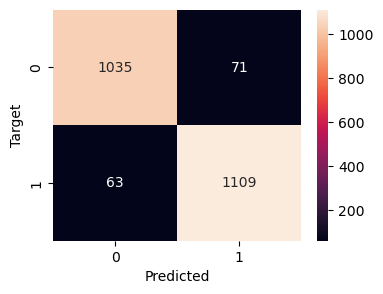

In [28]:
eval_results = utils.evaluate_model(model, x_train_vec, y_train, x_test_vec, y_test)
utils.plot_confusion_matrix(eval_results['confusion_matrix'], model.classes_)

#### With TfidfVectorizer
```
train accuracy: 0.96619
test accuracy:  0.93635
test precision: 0.94537
test recall:    0.92231
test F1 score:  0.9337
```

#### With CountVectorizer
```
train accuracy: 0.99971
test accuracy:  0.93679
test precision: 0.94053
test recall:    0.92864
test F1 score:  0.93455
```


### SVM

**NOTE:** SVM fails with CountVectorizer (even with application of StandardScaler and increased `max_iter`), but succeeds with TfidfVectorizer.  

In [23]:
model = LinearSVC(C=1) 
x_train_svm = None

if isinstance(vectorizer, CountVectorizer):
    print("skipping SVM with CountVectorizer")
    # scaler = StandardScaler(with_mean=False)
    # x_train_svm = scaler.fit_transform(x_train_vec)
    # x_test_svm = scaler.fit_transform(x_test_vec)
    # model = LinearSVC(max_iter=10000)
    # model.fit(x_train_svm, y_train)
else:
    x_train_svm = x_train_vec
    model.fit(x_train_svm, y_train)

skipping SVM with CountVectorizer


In [24]:
if isinstance(vectorizer, CountVectorizer):
    print("skipping SVM with CountVectorizer")
else:
    conf_mat = utils.evaluate_model(model, x_train_vec, y_train, x_test_vec, y_test)
    utils.plot_confusion_matrix(conf_mat, model.classes_)

skipping SVM with CountVectorizer


#### With TfidfVectorizer
```
train accuracy: 0.96619
test accuracy:  0.93635
test precision: 0.94537
test recall:    0.92231
test F1 score:  0.9337
```

## With SVD/LSA (dimension reduction)

### Testing with increasing number of components

In [62]:
stats = {}
stats['n_comp_range'] = [1, 2, 3, 5, 10, 20, 40, 80, 100]
stats['accuracy'] = []
stats['precision'] = []
stats['recall'] = []
print(stats)
for n_components in n_comp_range:
    svd = TruncatedSVD(n_components=n_components)
    Z_train = svd.fit_transform(x_train_vec)
    Z_test = svd.transform(x_test_vec)
    model = LogisticRegression() 
    model.fit(Z_train, y_train)
    e = utils.evaluate_model(model, Z_train, y_train, Z_test, y_test, verbose = False)
    print(f'n_components={n_components}; accuracy={e['accuracy']}')

    stats['accuracy'].append(e['accuracy'])
    stats['precision'].append(e['precision'])
    stats['recall'].append(e['recall'])


{'n_comp_range': [1, 2, 3, 5, 10, 20, 40, 80, 100], 'accuracy': [], 'precision': [], 'recall': []}
n_components=1; accuracy=0.62071992976295
n_components=2; accuracy=0.7761194029850746
n_components=3; accuracy=0.771729587357331
n_components=5; accuracy=0.8116769095697981
n_components=10; accuracy=0.8814749780509219
n_components=20; accuracy=0.8871817383669885
n_components=40; accuracy=0.9029850746268657
n_components=80; accuracy=0.908252853380158
n_components=100; accuracy=0.9095697980684812


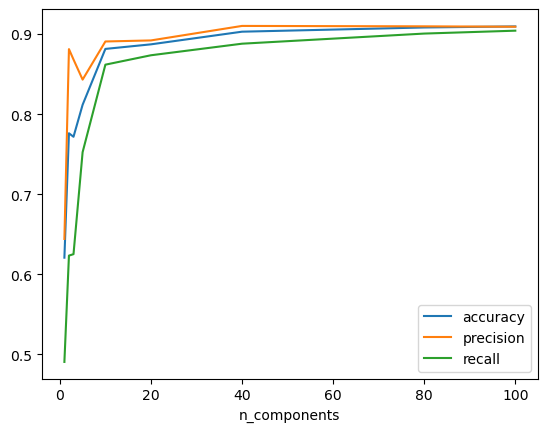

In [64]:
## Plot statistics of benchmark
plt.plot(n_comp_range, stats['accuracy'], label = "accuracy")
plt.plot(n_comp_range, stats['precision'], label = "precision")
plt.plot(n_comp_range, stats['recall'], label = "recall")
plt.xlabel("n_components")
plt.legend()
plt.show;

**conclusion** SVD does not seem to be very helpful here.  
**question** why has dimension reduction no positive effect here?  
The course exercise states "Compare both methods (with and without SVD) by using the same number of features for each." --> What is meant by that?